# 导入相关的package

In [145]:
# 基础的package
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import os
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

# 模型相关的package
from xgboost import XGBClassifier, plot_importance
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

### 画图全局设置

In [65]:
plt.rcParams['figure.figsize'] = (20,5)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.axisbelow'] = True
colors = ['#44A948', '#137CB1', '#EACC80', '#A8D7E2', '#E58061']

# 数据相关的函数

### 计算收益率的文件，希望是一个字典，然后每个品种对应一个DataFrame,纵轴是时间，横轴是收益率，收益率为一分钟，五分钟和十分钟，二十分钟以及一个小时。

### 计算因子，然后滞后一分钟，因为害怕出现未来函数

### 刚开始最主要的是判断出，那天是期权的行权日, 然后进行分段的处理

### 如果可以的话，希望可以预测三个模型，因为希望可以对极端行情有更好的适应性

### 读取数据并去除重复行

### 读取期权快照数据

In [66]:
# 读取未经过处理的数据，需要判断行权日以及空缺值，还需要观察形态
def get_snapshot():
    snapshot = pd.read_csv('./csv/market.csv',index_col = None, header = None)
    snapshot.columns = ['kind','datetime','open','high','low','close','vol']
    snapshot.drop_duplicates(inplace=True)
    snapshot.reset_index(drop=True,inplace=True)
    return snapshot

### 读取逐笔成交数据

In [67]:
def get_tick():
    tick = pd.read_csv('./csv/depth.csv',index_col = None, header = None)
    tick.columns = ['amount', 'price', 'datetime', 'type', 'kind']
    tick.drop_duplicates(inplace=True)
    tick.reset_index(drop=True,inplace=True)
    return tick

### 读取现货数据

In [73]:
def get_spot():
    spot = pd.read_csv('./csv/spot.csv',index_col = None,header = None)
    spot.columns = ['datetime', 'kind', 'open', 'high', 'low', 'close', 'vol']
    spot.drop_duplicates(inplace=True)
    spot.reset_index(drop=True,inplace=True)
    return spot

### 期权 填充时间轴

In [74]:
def get_digit_opt_continue(digit_name, snapshot):
    y = snapshot[snapshot['kind'] == digit_name]
    y = y.groupby('datetime').tail(1).set_index('datetime')

    timeline = pd.date_range(y.index[0], y.index[-1], freq = '1min')
    timeline = list(map(str, timeline))

    _timeline = []
    for i in timeline:
        if i not in y.index:
            _timeline.append(i)

    _y = pd.DataFrame(
        [[digit_name,np.nan,np.nan,np.nan,np.nan,np.nan]]*len(_timeline),
        index = _timeline,
        columns=y.columns,
    )

    y = pd.concat([_y,y]).sort_index()
    return y

### 获得某一个种类的现货数据

In [75]:
def get_digit(name,spot):
    return  spot[spot.kind == name]

### 判断行权日（不精确）

In [76]:
def get_strike_day(opt):
    st = opt.apply(lambda x:(np.isnan(x.close)) and (x.name[-8:-6]=='16'),axis = 1)
    st = st[st]
    st.index = st.index.map(lambda x:x[:10])
    st = st.groupby(st.index).sum()

    ans = st[st == 60].index.tolist()
    return ans

In [77]:
%%time
snapshot = get_snapshot()
tick = get_tick()
spot = get_spot()

Wall time: 2min 51s


In [78]:
# 暂时主要是快照的数据来构造特征，所以先对快照数据进行清洗以及填充
# 2020-03-18 23:31 有异常值，都3000了，应该去除，或者采用open填充,发现这些异常值都集中在market0_552_1中
# 所以可以先不考虑这个品种
print(snapshot.shape)
print(tick.shape)
print(spot.shape)

(9053680, 7)
(5383951, 5)
(26561891, 7)


In [79]:
for i in np.sort(snapshot.kind.drop_duplicates().values):
    print(i, end = " | ")

market0_472_1 | market0_473_1 | market0_486_1 | market0_487_1 | market0_490_1 | market0_491_1 | market0_514_1 | market0_515_1 | market0_516_1 | market0_517_1 | market0_518_1 | market0_519_1 | market0_522_1 | market0_523_1 | market0_526_1 | market0_527_1 | market0_530_1 | market0_531_1 | market0_532_1 | market0_533_1 | market0_541_1 | market0_542_1 | market0_544_1 | market0_545_1 | market0_546_1 | market0_547_1 | market0_548_1 | market0_549_1 | market0_551_1 | market0_552_1 | 

In [80]:
%%time
digit_name_c0 = 'market0_486_1'
digit_name_p0 = 'market0_487_1'
digit_name_c1 = 'market0_516_1'
digit_name_p1 = 'market0_517_1'

c0 = get_digit_opt_continue(digit_name_c0,snapshot)
p0 = get_digit_opt_continue(digit_name_p0,snapshot)
c1 = get_digit_opt_continue(digit_name_c1,snapshot)
p1 = get_digit_opt_continue(digit_name_p1,snapshot)
y = get_digit('BTCP', spot)

Wall time: 11.6 s


In [81]:
%%time
print(get_strike_day(c0))
print(get_strike_day(p0))
print(get_strike_day(c1))
print(get_strike_day(p1))

['2020-03-18', '2020-04-22', '2020-05-20']
['2020-03-18', '2020-04-22', '2020-05-20']
['2020-03-04', '2020-04-08', '2020-05-06']
['2020-03-04', '2020-04-08', '2020-05-06']
Wall time: 15 s


### 分段画出期权的图像

In [19]:
# 画图
def plot_opt(y,ans):
    start,end = ' 17:00:00', ' 15:59:00'
    for i in range(len(ans)):
        if i == 0:
            y.loc[:ans[0] + end,'close'].plot(figsize = (20,5),color = colors[4])
            plt.show()
        else:
            y.loc[ans[i-1] + start:ans[i] + end, 'close'].plot(figsize = (20,5),color = colors[4])
            plt.show()
        if i == len(ans) - 1:
            y.loc[ans[len(ans)-1] + start:,'close'].plot(figsize = (20,5),color = colors[4])
            plt.show()

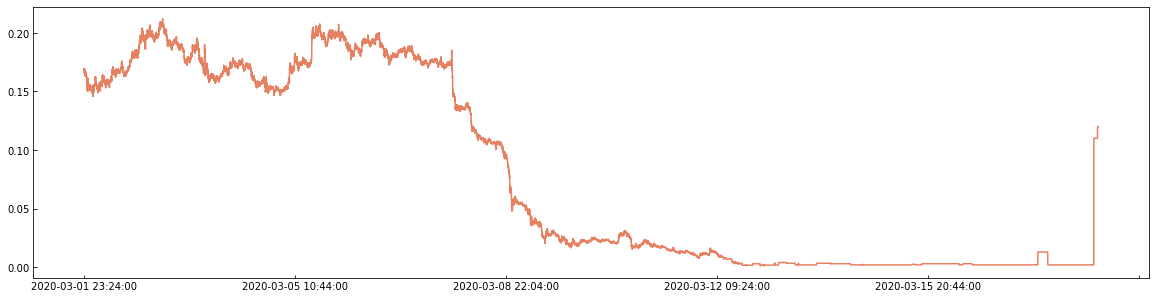

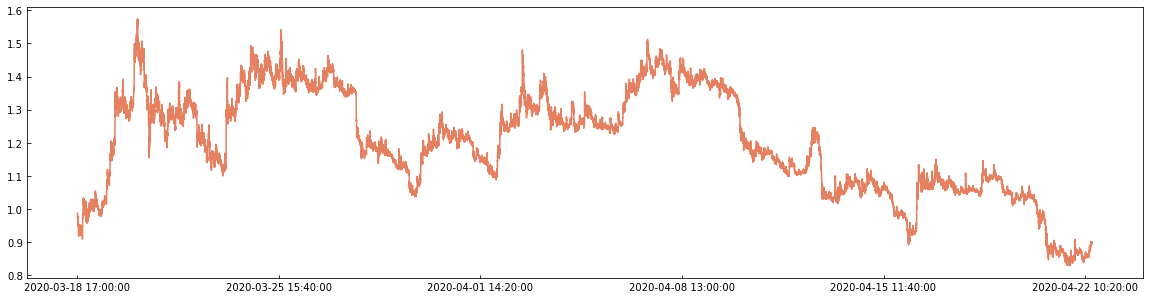

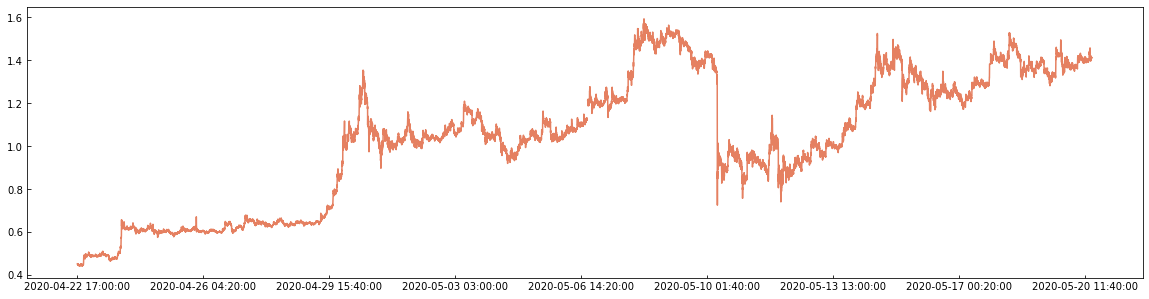

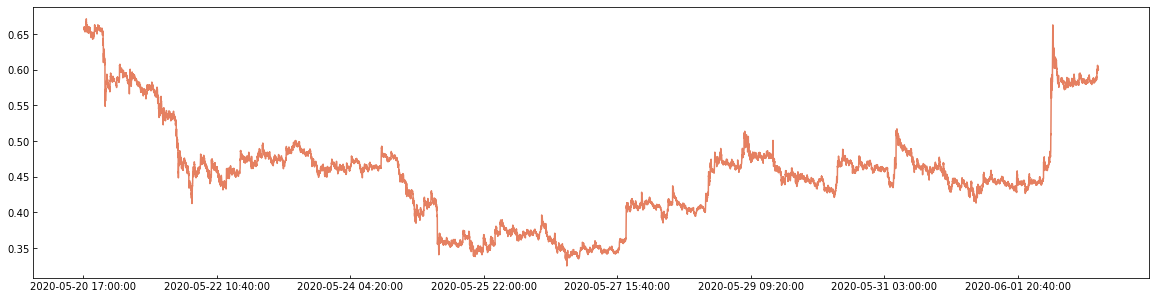

In [46]:
plot_opt(c0, get_strike_day(c0))

In [35]:
%%time
# 查找所有期权的
for i in np.sort(snapshot.kind.drop_duplicates().values):
    opt = get_digit_opt_continue(i,snapshot)
    ans = get_strike_day(opt)
    print('\n','======== ',i,' =======',end = '\n\n')
    start,end = ' 17:00:00', ' 15:59:00'
    print(ans)


 ========  market0_472_1  =======

['2020-03-16', '2020-04-20', '2020-05-18']

 ========  market0_473_1  =======

['2020-03-16', '2020-04-20', '2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-18']

 ========  market0_486_1  =======

['2020-03-18', '2020-04-22', '2020-05-20']

 ========  market0_487_1  =======

['2020-03-18', '2020-04-22', '2020-05-20']

 ========  market0_490_1  =======

['2020-03-19', '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-23', '2020-05-21']

 ========  market0_491_1  =======

['2020-03-19', '2020-04-23', '2020-05-07', '2020-05-08', '2020-05-09', '2020-05-10', '2020-05-12', '2020-05-21']

 ========  market0_514_1  =======

['2020-03-04', '2020-03-11', '2020-03-18', '2020-03-25', '2020-04-01', '2020-04-08', '2020-04-15', '2020-04-22', '2020-04-29', '2020-05-06', '2020-05-13', '2020-05-20', '2020-05-27']

 ========  market0_515_1  =======

['2020-03-04', '2020-03-11', '2020-03-18', '2020-03-25', '202

### 计算因子，滞后一分钟

In [41]:
get_strike_day(c0)

['2020-03-18', '2020-04-22', '2020-05-20']

In [83]:
y.datetime = y.datetime.apply(lambda x:x[:4]+ '-' + x[4:6] + '-' + x[6:8] + x[8:] + ':00')
y.set_index('datetime', inplace = True)

In [156]:
def f(x):
    if x>=0.002:
        return 1
    elif x<=-0.002:
        return -1
    else:
        return 0
f = np.vectorize(f)

0  /  12392   1   -1
1  /  12392   0   1
2  /  12392   1   -1
3  /  12392   0   -1
4  /  12392   -1   -1
5  /  12392   1   -1
6  /  12392   1   1
7  /  12392   1   1
8  /  12392   1   1
9  /  12392   1   1
10  /  12392   1   1
11  /  12392   1   1
12  /  12392   1   1
13  /  12392   1   1
14  /  12392   1   1
15  /  12392   1   1
16  /  12392   1   1
17  /  12392   1   1
18  /  12392   -1   1
19  /  12392   -1   1
20  /  12392   -1   -1
21  /  12392   -1   -1
22  /  12392   -1   1
23  /  12392   -1   1
24  /  12392   -1   -1
25  /  12392   -1   -1
26  /  12392   -1   -1
27  /  12392   -1   -1
28  /  12392   -1   -1
29  /  12392   -1   -1
30  /  12392   -1   -1
31  /  12392   -1   -1
32  /  12392   -1   -1
33  /  12392   -1   -1
34  /  12392   -1   -1
35  /  12392   -1   -1
36  /  12392   -1   -1
37  /  12392   1   -1
38  /  12392   1   1
39  /  12392   -1   1
40  /  12392   -1   1
41  /  12392   -1   -1
42  /  12392   -1   -1
43  /  12392   -1   -1
44  /  12392   -1   -1
45  /  12392  

360  /  12392   1   1
361  /  12392   1   1
362  /  12392   1   1
363  /  12392   1   1
364  /  12392   1   1
365  /  12392   1   1
366  /  12392   0   1
367  /  12392   0   1
368  /  12392   -1   0
369  /  12392   -1   -1
370  /  12392   -1   -1
371  /  12392   -1   -1
372  /  12392   -1   -1
373  /  12392   -1   -1
374  /  12392   -1   -1
375  /  12392   -1   -1
376  /  12392   -1   -1
377  /  12392   -1   -1
378  /  12392   -1   -1
379  /  12392   -1   -1
380  /  12392   -1   -1
381  /  12392   -1   -1
382  /  12392   -1   -1
383  /  12392   -1   -1
384  /  12392   0   -1
385  /  12392   1   -1
386  /  12392   1   -1
387  /  12392   1   1
388  /  12392   -1   -1
389  /  12392   0   -1
390  /  12392   -1   0
391  /  12392   -1   -1
392  /  12392   -1   -1
393  /  12392   -1   -1
394  /  12392   -1   -1
395  /  12392   -1   -1
396  /  12392   -1   -1
397  /  12392   -1   -1
398  /  12392   1   -1
399  /  12392   0   -1
400  /  12392   -1   -1
401  /  12392   0   -1
402  /  12392   1  

713  /  12392   -1   -1
714  /  12392   -1   -1
715  /  12392   -1   -1
716  /  12392   -1   -1
717  /  12392   -1   -1
718  /  12392   -1   -1
719  /  12392   1   -1
720  /  12392   1   1
721  /  12392   1   1
722  /  12392   1   1
723  /  12392   1   1
724  /  12392   1   1
725  /  12392   1   1
726  /  12392   1   1
727  /  12392   1   1
728  /  12392   1   1
729  /  12392   0   1
730  /  12392   -1   -1
731  /  12392   -1   -1
732  /  12392   0   -1
733  /  12392   0   -1
734  /  12392   0   -1
735  /  12392   0   -1
736  /  12392   1   0
737  /  12392   1   1
738  /  12392   1   1
739  /  12392   1   1
740  /  12392   1   1
741  /  12392   1   1
742  /  12392   1   1
743  /  12392   0   1
744  /  12392   1   0
745  /  12392   1   1
746  /  12392   1   1
747  /  12392   1   1
748  /  12392   1   1
749  /  12392   1   1
750  /  12392   1   -1
751  /  12392   1   1
752  /  12392   1   1
753  /  12392   1   1
754  /  12392   1   1
755  /  12392   1   1
756  /  12392   1   1
757  /  12

1065  /  12392   -1   -1
1066  /  12392   -1   -1
1067  /  12392   -1   1
1068  /  12392   -1   -1
1069  /  12392   -1   -1
1070  /  12392   -1   1
1071  /  12392   1   -1
1072  /  12392   0   -1
1073  /  12392   1   -1
1074  /  12392   0   -1
1075  /  12392   -1   -1
1076  /  12392   -1   -1
1077  /  12392   -1   -1
1078  /  12392   -1   -1
1079  /  12392   -1   -1
1080  /  12392   -1   -1
1081  /  12392   -1   -1
1082  /  12392   -1   -1
1083  /  12392   -1   -1
1084  /  12392   -1   -1
1085  /  12392   -1   -1
1086  /  12392   -1   -1
1087  /  12392   -1   -1
1088  /  12392   1   -1
1089  /  12392   1   -1
1090  /  12392   1   1
1091  /  12392   1   1
1092  /  12392   1   1
1093  /  12392   1   1
1094  /  12392   1   1
1095  /  12392   1   -1
1096  /  12392   0   1
1097  /  12392   -1   1
1098  /  12392   -1   -1
1099  /  12392   -1   -1
1100  /  12392   -1   -1
1101  /  12392   -1   -1
1102  /  12392   -1   -1
1103  /  12392   -1   -1
1104  /  12392   -1   -1
1105  /  12392   -1   

1404  /  12392   -1   -1
1405  /  12392   -1   -1
1406  /  12392   -1   1
1407  /  12392   0   -1
1408  /  12392   -1   -1
1409  /  12392   -1   -1
1410  /  12392   -1   -1
1411  /  12392   -1   -1
1412  /  12392   0   -1
1413  /  12392   1   0
1414  /  12392   0   -1
1415  /  12392   1   1
1416  /  12392   1   1
1417  /  12392   1   -1
1418  /  12392   1   1
1419  /  12392   1   1
1420  /  12392   1   1
1421  /  12392   1   1
1422  /  12392   1   1
1423  /  12392   1   1
1424  /  12392   1   1
1425  /  12392   0   1
1426  /  12392   0   1
1427  /  12392   1   1
1428  /  12392   0   1
1429  /  12392   0   0
1430  /  12392   1   1
1431  /  12392   1   1
1432  /  12392   1   1
1433  /  12392   1   1
1434  /  12392   1   1
1435  /  12392   1   1
1436  /  12392   1   1
1437  /  12392   0   1
1438  /  12392   -1   0
1439  /  12392   -1   -1
1440  /  12392   -1   -1
1441  /  12392   -1   -1
1442  /  12392   -1   -1
1443  /  12392   -1   -1
1444  /  12392   -1   -1
1445  /  12392   -1   -1
14

1746  /  12392   0   1
1747  /  12392   -1   1
1748  /  12392   -1   1
1749  /  12392   -1   -1
1750  /  12392   0   -1
1751  /  12392   -1   -1
1752  /  12392   -1   1
1753  /  12392   -1   -1
1754  /  12392   -1   -1
1755  /  12392   -1   -1
1756  /  12392   0   -1
1757  /  12392   0   -1
1758  /  12392   0   -1
1759  /  12392   0   0
1760  /  12392   1   0
1761  /  12392   1   0
1762  /  12392   1   0
1763  /  12392   1   -1
1764  /  12392   1   1
1765  /  12392   1   1
1766  /  12392   1   1
1767  /  12392   1   1
1768  /  12392   1   1
1769  /  12392   1   1
1770  /  12392   1   1
1771  /  12392   -1   1
1772  /  12392   0   -1
1773  /  12392   1   0
1774  /  12392   1   1
1775  /  12392   0   1
1776  /  12392   1   1
1777  /  12392   0   1
1778  /  12392   -1   0
1779  /  12392   -1   -1
1780  /  12392   -1   -1
1781  /  12392   -1   -1
1782  /  12392   -1   -1
1783  /  12392   -1   -1
1784  /  12392   -1   -1
1785  /  12392   -1   -1
1786  /  12392   -1   -1
1787  /  12392   -1 

2087  /  12392   1   1
2088  /  12392   1   1
2089  /  12392   1   1
2090  /  12392   1   1
2091  /  12392   -1   1
2092  /  12392   -1   -1
2093  /  12392   -1   -1
2094  /  12392   -1   -1
2095  /  12392   -1   -1
2096  /  12392   -1   -1
2097  /  12392   -1   -1
2098  /  12392   -1   -1
2099  /  12392   -1   -1
2100  /  12392   -1   -1
2101  /  12392   0   -1
2102  /  12392   0   -1
2103  /  12392   0   -1
2104  /  12392   1   -1
2105  /  12392   1   1
2106  /  12392   1   1
2107  /  12392   0   -1
2108  /  12392   0   -1
2109  /  12392   0   0
2110  /  12392   -1   1
2111  /  12392   -1   -1
2112  /  12392   0   -1
2113  /  12392   0   0
2114  /  12392   -1   0
2115  /  12392   0   -1
2116  /  12392   1   0
2117  /  12392   1   1
2118  /  12392   1   1
2119  /  12392   1   1
2120  /  12392   1   1
2121  /  12392   1   1
2122  /  12392   1   1
2123  /  12392   1   1
2124  /  12392   1   1
2125  /  12392   1   1
2126  /  12392   1   1
2127  /  12392   1   1
2128  /  12392   1   1
212

2430  /  12392   1   0
2431  /  12392   -1   -1
2432  /  12392   -1   -1
2433  /  12392   -1   -1
2434  /  12392   -1   -1
2435  /  12392   -1   -1
2436  /  12392   -1   -1
2437  /  12392   0   -1
2438  /  12392   0   -1
2439  /  12392   0   -1
2440  /  12392   0   -1
2441  /  12392   0   0
2442  /  12392   1   0
2443  /  12392   0   1
2444  /  12392   0   0
2445  /  12392   -1   0
2446  /  12392   -1   -1
2447  /  12392   -1   -1
2448  /  12392   -1   -1
2449  /  12392   -1   0
2450  /  12392   -1   -1
2451  /  12392   -1   -1
2452  /  12392   -1   -1
2453  /  12392   1   -1
2454  /  12392   1   1
2455  /  12392   1   -1
2456  /  12392   1   1
2457  /  12392   1   1
2458  /  12392   1   1
2459  /  12392   1   1
2460  /  12392   1   1
2461  /  12392   1   1
2462  /  12392   1   -1
2463  /  12392   1   1
2464  /  12392   1   1
2465  /  12392   1   1
2466  /  12392   1   1
2467  /  12392   0   1
2468  /  12392   0   1
2469  /  12392   0   1
2470  /  12392   -1   1
2471  /  12392   -1   -

2772  /  12392   1   1
2773  /  12392   1   1
2774  /  12392   1   1
2775  /  12392   1   1
2776  /  12392   1   1
2777  /  12392   1   1
2778  /  12392   1   1
2779  /  12392   1   1
2780  /  12392   0   1
2781  /  12392   0   1
2782  /  12392   -1   1
2783  /  12392   -1   -1
2784  /  12392   -1   -1
2785  /  12392   0   -1
2786  /  12392   0   -1
2787  /  12392   0   -1
2788  /  12392   1   0
2789  /  12392   1   1
2790  /  12392   0   1
2791  /  12392   0   1
2792  /  12392   0   0
2793  /  12392   1   0
2794  /  12392   1   1
2795  /  12392   1   0
2796  /  12392   1   1
2797  /  12392   1   1
2798  /  12392   1   1
2799  /  12392   1   1
2800  /  12392   1   1
2801  /  12392   1   1
2802  /  12392   1   1
2803  /  12392   0   1
2804  /  12392   0   1
2805  /  12392   -1   1
2806  /  12392   -1   -1
2807  /  12392   -1   1
2808  /  12392   -1   -1
2809  /  12392   -1   1
2810  /  12392   -1   -1
2811  /  12392   -1   -1
2812  /  12392   -1   -1
2813  /  12392   -1   -1
2814  /  12

3113  /  12392   -1   1
3114  /  12392   -1   1
3115  /  12392   -1   -1
3116  /  12392   1   -1
3117  /  12392   1   -1
3118  /  12392   1   1
3119  /  12392   1   1
3120  /  12392   1   1
3121  /  12392   1   1
3122  /  12392   1   0
3123  /  12392   1   1
3124  /  12392   1   1
3125  /  12392   1   1
3126  /  12392   1   1
3127  /  12392   1   1
3128  /  12392   1   1
3129  /  12392   1   1
3130  /  12392   0   1
3131  /  12392   0   0
3132  /  12392   -1   0
3133  /  12392   -1   -1
3134  /  12392   -1   -1
3135  /  12392   -1   -1
3136  /  12392   -1   -1
3137  /  12392   -1   -1
3138  /  12392   -1   -1
3139  /  12392   -1   -1
3140  /  12392   -1   -1
3141  /  12392   -1   -1
3142  /  12392   1   -1
3143  /  12392   1   1
3144  /  12392   1   1
3145  /  12392   1   1
3146  /  12392   1   1
3147  /  12392   1   1
3148  /  12392   1   1
3149  /  12392   1   1
3150  /  12392   0   1
3151  /  12392   0   0
3152  /  12392   -1   1
3153  /  12392   -1   -1
3154  /  12392   -1   -1
315

3454  /  12392   0   1
3455  /  12392   0   -1
3456  /  12392   -1   0
3457  /  12392   -1   -1
3458  /  12392   -1   -1
3459  /  12392   -1   -1
3460  /  12392   -1   -1
3461  /  12392   0   -1
3462  /  12392   0   -1
3463  /  12392   0   1
3464  /  12392   0   0
3465  /  12392   -1   0
3466  /  12392   0   0
3467  /  12392   0   1
3468  /  12392   0   0
3469  /  12392   1   0
3470  /  12392   1   1
3471  /  12392   0   1
3472  /  12392   -1   0
3473  /  12392   -1   -1
3474  /  12392   -1   -1
3475  /  12392   -1   -1
3476  /  12392   -1   -1
3477  /  12392   -1   -1
3478  /  12392   -1   -1
3479  /  12392   -1   -1
3480  /  12392   -1   -1
3481  /  12392   -1   -1
3482  /  12392   0   -1
3483  /  12392   1   -1
3484  /  12392   1   -1
3485  /  12392   1   1
3486  /  12392   1   1
3487  /  12392   1   1
3488  /  12392   1   0
3489  /  12392   1   1
3490  /  12392   1   1
3491  /  12392   1   1
3492  /  12392   1   1
3493  /  12392   1   1
3494  /  12392   0   1
3495  /  12392   -1   

3795  /  12392   1   -1
3796  /  12392   0   1
3797  /  12392   0   0
3798  /  12392   -1   0
3799  /  12392   0   0
3800  /  12392   0   0
3801  /  12392   -1   -1
3802  /  12392   -1   -1
3803  /  12392   -1   -1
3804  /  12392   0   -1
3805  /  12392   0   0
3806  /  12392   1   0
3807  /  12392   1   0
3808  /  12392   1   1
3809  /  12392   1   1
3810  /  12392   0   1
3811  /  12392   0   1
3812  /  12392   1   0
3813  /  12392   1   1
3814  /  12392   0   1
3815  /  12392   1   1
3816  /  12392   1   0
3817  /  12392   1   1
3818  /  12392   1   1
3819  /  12392   1   1
3820  /  12392   1   1
3821  /  12392   1   1
3822  /  12392   1   1
3823  /  12392   1   1
3824  /  12392   1   1
3825  /  12392   1   1
3826  /  12392   1   1
3827  /  12392   1   1
3828  /  12392   0   -1
3829  /  12392   -1   -1
3830  /  12392   -1   -1
3831  /  12392   -1   -1
3832  /  12392   0   -1
3833  /  12392   -1   0
3834  /  12392   -1   -1
3835  /  12392   -1   -1
3836  /  12392   -1   -1
3837  /  1

4139  /  12392   1   1
4140  /  12392   1   1
4141  /  12392   1   -1
4142  /  12392   1   1
4143  /  12392   1   1
4144  /  12392   1   1
4145  /  12392   1   1
4146  /  12392   1   1
4147  /  12392   1   1
4148  /  12392   -1   1
4149  /  12392   -1   -1
4150  /  12392   -1   -1
4151  /  12392   -1   1
4152  /  12392   -1   -1
4153  /  12392   -1   -1
4154  /  12392   -1   -1
4155  /  12392   -1   -1
4156  /  12392   -1   -1
4157  /  12392   -1   -1
4158  /  12392   -1   -1
4159  /  12392   -1   -1
4160  /  12392   1   -1
4161  /  12392   1   -1
4162  /  12392   1   1
4163  /  12392   1   1
4164  /  12392   1   1
4165  /  12392   0   1
4166  /  12392   -1   1
4167  /  12392   -1   -1
4168  /  12392   0   -1
4169  /  12392   0   0
4170  /  12392   -1   -1
4171  /  12392   -1   -1
4172  /  12392   -1   -1
4173  /  12392   -1   0
4174  /  12392   -1   0
4175  /  12392   1   0
4176  /  12392   0   1
4177  /  12392   1   0
4178  /  12392   -1   1
4179  /  12392   -1   -1
4180  /  12392   

4481  /  12392   -1   -1
4482  /  12392   -1   -1
4483  /  12392   -1   -1
4484  /  12392   -1   1
4485  /  12392   -1   -1
4486  /  12392   -1   -1
4487  /  12392   -1   -1
4488  /  12392   1   -1
4489  /  12392   -1   1
4490  /  12392   1   -1
4491  /  12392   0   -1
4492  /  12392   1   1
4493  /  12392   1   1
4494  /  12392   0   1
4495  /  12392   -1   1
4496  /  12392   1   -1
4497  /  12392   1   1
4498  /  12392   0   1
4499  /  12392   1   1
4500  /  12392   0   1
4501  /  12392   1   1
4502  /  12392   0   1
4503  /  12392   1   1
4504  /  12392   1   0
4505  /  12392   1   1
4506  /  12392   -1   1
4507  /  12392   -1   1
4508  /  12392   -1   -1
4509  /  12392   -1   -1
4510  /  12392   -1   -1
4511  /  12392   -1   -1
4512  /  12392   -1   -1
4513  /  12392   -1   -1
4514  /  12392   -1   -1
4515  /  12392   -1   -1
4516  /  12392   -1   -1
4517  /  12392   0   -1
4518  /  12392   0   1
4519  /  12392   -1   0
4520  /  12392   -1   -1
4521  /  12392   -1   -1
4522  /  123

4819  /  12392   1   1
4820  /  12392   1   1
4821  /  12392   1   1
4822  /  12392   1   1
4823  /  12392   1   1
4824  /  12392   1   1
4825  /  12392   -1   1
4826  /  12392   -1   -1
4827  /  12392   -1   -1
4828  /  12392   -1   -1
4829  /  12392   -1   -1
4830  /  12392   -1   -1
4831  /  12392   -1   -1
4832  /  12392   -1   -1
4833  /  12392   -1   -1
4834  /  12392   -1   -1
4835  /  12392   -1   -1
4836  /  12392   -1   -1
4837  /  12392   -1   1
4838  /  12392   -1   -1
4839  /  12392   -1   -1
4840  /  12392   -1   1
4841  /  12392   -1   -1
4842  /  12392   0   -1
4843  /  12392   0   -1
4844  /  12392   0   1
4845  /  12392   1   0
4846  /  12392   0   1
4847  /  12392   1   0
4848  /  12392   1   1
4849  /  12392   1   1
4850  /  12392   0   1
4851  /  12392   0   1
4852  /  12392   -1   0
4853  /  12392   0   -1
4854  /  12392   -1   0
4855  /  12392   -1   -1
4856  /  12392   -1   -1
4857  /  12392   -1   -1
4858  /  12392   -1   -1
4859  /  12392   0   -1
4860  /  123

5161  /  12392   -1   -1
5162  /  12392   -1   -1
5163  /  12392   -1   -1
5164  /  12392   -1   -1
5165  /  12392   -1   -1
5166  /  12392   -1   -1
5167  /  12392   -1   -1
5168  /  12392   1   -1
5169  /  12392   0   -1
5170  /  12392   -1   -1
5171  /  12392   -1   -1
5172  /  12392   -1   -1
5173  /  12392   -1   -1
5174  /  12392   -1   -1
5175  /  12392   -1   -1
5176  /  12392   -1   -1
5177  /  12392   -1   -1
5178  /  12392   -1   -1
5179  /  12392   -1   -1
5180  /  12392   -1   -1
5181  /  12392   -1   -1
5182  /  12392   -1   -1
5183  /  12392   -1   -1
5184  /  12392   -1   -1
5185  /  12392   -1   -1
5186  /  12392   -1   -1
5187  /  12392   -1   -1
5188  /  12392   -1   -1
5189  /  12392   -1   -1
5190  /  12392   -1   -1
5191  /  12392   -1   -1
5192  /  12392   -1   -1
5193  /  12392   -1   -1
5194  /  12392   1   -1
5195  /  12392   0   1
5196  /  12392   -1   -1
5197  /  12392   1   -1
5198  /  12392   1   -1
5199  /  12392   1   1
5200  /  12392   0   1
5201  /  12

5501  /  12392   -1   -1
5502  /  12392   -1   -1
5503  /  12392   0   -1
5504  /  12392   1   -1
5505  /  12392   1   -1
5506  /  12392   1   -1
5507  /  12392   1   -1
5508  /  12392   1   1
5509  /  12392   1   1
5510  /  12392   1   -1
5511  /  12392   1   1
5512  /  12392   1   1
5513  /  12392   1   1
5514  /  12392   1   1
5515  /  12392   1   1
5516  /  12392   1   1
5517  /  12392   0   1
5518  /  12392   -1   1
5519  /  12392   -1   -1
5520  /  12392   -1   -1
5521  /  12392   -1   -1
5522  /  12392   -1   -1
5523  /  12392   -1   -1
5524  /  12392   -1   -1
5525  /  12392   -1   -1
5526  /  12392   -1   -1
5527  /  12392   -1   -1
5528  /  12392   -1   -1
5529  /  12392   -1   -1
5530  /  12392   -1   -1
5531  /  12392   -1   -1
5532  /  12392   -1   -1
5533  /  12392   -1   -1
5534  /  12392   -1   -1
5535  /  12392   -1   -1
5536  /  12392   -1   -1
5537  /  12392   -1   -1
5538  /  12392   -1   -1
5539  /  12392   -1   -1
5540  /  12392   -1   -1
5541  /  12392   -1   -1


5843  /  12392   -1   -1
5844  /  12392   -1   -1
5845  /  12392   0   -1
5846  /  12392   -1   -1
5847  /  12392   -1   -1
5848  /  12392   -1   -1
5849  /  12392   -1   -1
5850  /  12392   -1   -1
5851  /  12392   -1   -1
5852  /  12392   -1   -1
5853  /  12392   -1   -1
5854  /  12392   -1   -1
5855  /  12392   -1   -1
5856  /  12392   0   -1
5857  /  12392   1   -1
5858  /  12392   -1   1
5859  /  12392   -1   -1
5860  /  12392   -1   -1
5861  /  12392   -1   -1
5862  /  12392   -1   -1
5863  /  12392   -1   -1
5864  /  12392   -1   -1
5865  /  12392   -1   -1
5866  /  12392   -1   -1
5867  /  12392   -1   -1
5868  /  12392   -1   -1
5869  /  12392   -1   -1
5870  /  12392   -1   -1
5871  /  12392   1   -1
5872  /  12392   1   -1
5873  /  12392   1   -1
5874  /  12392   1   -1
5875  /  12392   1   1
5876  /  12392   1   1
5877  /  12392   0   1
5878  /  12392   1   1
5879  /  12392   1   1
5880  /  12392   1   1
5881  /  12392   1   1
5882  /  12392   -1   1
5883  /  12392   0   -1

6184  /  12392   1   1
6185  /  12392   1   1
6186  /  12392   1   1
6187  /  12392   1   1
6188  /  12392   1   1
6189  /  12392   1   1
6190  /  12392   1   1
6191  /  12392   0   1
6192  /  12392   -1   1
6193  /  12392   -1   -1
6194  /  12392   -1   -1
6195  /  12392   -1   -1
6196  /  12392   -1   -1
6197  /  12392   -1   -1
6198  /  12392   -1   1
6199  /  12392   -1   -1
6200  /  12392   -1   -1
6201  /  12392   -1   1
6202  /  12392   -1   -1
6203  /  12392   -1   -1
6204  /  12392   1   -1
6205  /  12392   1   1
6206  /  12392   0   1
6207  /  12392   1   1
6208  /  12392   -1   1
6209  /  12392   -1   1
6210  /  12392   1   1
6211  /  12392   1   -1
6212  /  12392   0   1
6213  /  12392   1   0
6214  /  12392   1   1
6215  /  12392   1   1
6216  /  12392   1   1
6217  /  12392   1   1
6218  /  12392   1   1
6219  /  12392   1   1
6220  /  12392   1   1
6221  /  12392   -1   1
6222  /  12392   -1   -1
6223  /  12392   0   -1
6224  /  12392   -1   1
6225  /  12392   -1   -1
62

6525  /  12392   -1   -1
6526  /  12392   -1   -1
6527  /  12392   -1   -1
6528  /  12392   -1   -1
6529  /  12392   -1   -1
6530  /  12392   0   -1
6531  /  12392   1   0
6532  /  12392   1   -1
6533  /  12392   1   1
6534  /  12392   1   1
6535  /  12392   1   1
6536  /  12392   1   1
6537  /  12392   1   1
6538  /  12392   1   1
6539  /  12392   1   1
6540  /  12392   0   1
6541  /  12392   -1   0
6542  /  12392   -1   0
6543  /  12392   -1   -1
6544  /  12392   -1   -1
6545  /  12392   -1   -1
6546  /  12392   -1   -1
6547  /  12392   -1   -1
6548  /  12392   -1   -1
6549  /  12392   -1   -1
6550  /  12392   -1   -1
6551  /  12392   -1   -1
6552  /  12392   -1   -1
6553  /  12392   0   -1
6554  /  12392   0   1
6555  /  12392   -1   1
6556  /  12392   -1   1
6557  /  12392   -1   -1
6558  /  12392   -1   -1
6559  /  12392   1   -1
6560  /  12392   1   -1
6561  /  12392   0   1
6562  /  12392   0   1
6563  /  12392   1   0
6564  /  12392   1   1
6565  /  12392   1   1
6566  /  12392

6866  /  12392   1   1
6867  /  12392   0   1
6868  /  12392   1   1
6869  /  12392   1   1
6870  /  12392   1   1
6871  /  12392   -1   1
6872  /  12392   -1   1
6873  /  12392   -1   -1
6874  /  12392   -1   -1
6875  /  12392   -1   1
6876  /  12392   -1   -1
6877  /  12392   0   -1
6878  /  12392   1   0
6879  /  12392   1   1
6880  /  12392   0   1
6881  /  12392   1   0
6882  /  12392   -1   1
6883  /  12392   -1   1
6884  /  12392   -1   1
6885  /  12392   0   1
6886  /  12392   -1   -1
6887  /  12392   -1   1
6888  /  12392   -1   -1
6889  /  12392   -1   1
6890  /  12392   -1   0
6891  /  12392   -1   -1
6892  /  12392   -1   -1
6893  /  12392   -1   -1
6894  /  12392   0   -1
6895  /  12392   0   0
6896  /  12392   0   0
6897  /  12392   0   -1
6898  /  12392   0   0
6899  /  12392   1   1
6900  /  12392   1   0
6901  /  12392   0   -1
6902  /  12392   1   0
6903  /  12392   1   1
6904  /  12392   0   1
6905  /  12392   -1   0
6906  /  12392   -1   0
6907  /  12392   0   1
690

7208  /  12392   -1   -1
7209  /  12392   -1   -1
7210  /  12392   0   -1
7211  /  12392   0   1
7212  /  12392   0   0
7213  /  12392   1   0
7214  /  12392   1   0
7215  /  12392   0   1
7216  /  12392   0   -1
7217  /  12392   1   -1
7218  /  12392   1   -1
7219  /  12392   1   1
7220  /  12392   -1   1
7221  /  12392   -1   -1
7222  /  12392   -1   -1
7223  /  12392   -1   -1
7224  /  12392   -1   -1
7225  /  12392   -1   -1
7226  /  12392   -1   -1
7227  /  12392   -1   -1
7228  /  12392   -1   -1
7229  /  12392   -1   0
7230  /  12392   -1   -1
7231  /  12392   -1   -1
7232  /  12392   -1   -1
7233  /  12392   1   -1
7234  /  12392   -1   -1
7235  /  12392   -1   -1
7236  /  12392   -1   1
7237  /  12392   -1   -1
7238  /  12392   -1   -1
7239  /  12392   -1   -1
7240  /  12392   -1   -1
7241  /  12392   -1   -1
7242  /  12392   -1   -1
7243  /  12392   -1   -1
7244  /  12392   -1   1
7245  /  12392   -1   -1
7246  /  12392   0   -1
7247  /  12392   0   -1
7248  /  12392   0   0


7547  /  12392   -1   -1
7548  /  12392   -1   -1
7549  /  12392   -1   -1
7550  /  12392   -1   -1
7551  /  12392   -1   -1
7552  /  12392   0   -1
7553  /  12392   1   -1
7554  /  12392   1   -1
7555  /  12392   1   -1
7556  /  12392   1   -1
7557  /  12392   1   -1
7558  /  12392   1   1
7559  /  12392   1   1
7560  /  12392   -1   -1
7561  /  12392   0   -1
7562  /  12392   -1   -1
7563  /  12392   -1   -1
7564  /  12392   -1   -1
7565  /  12392   -1   -1
7566  /  12392   -1   -1
7567  /  12392   -1   1
7568  /  12392   1   -1
7569  /  12392   0   1
7570  /  12392   1   -1
7571  /  12392   1   1
7572  /  12392   1   1
7573  /  12392   1   1
7574  /  12392   1   1
7575  /  12392   1   1
7576  /  12392   -1   1
7577  /  12392   -1   -1
7578  /  12392   -1   -1
7579  /  12392   -1   -1
7580  /  12392   -1   1
7581  /  12392   -1   -1
7582  /  12392   -1   -1
7583  /  12392   -1   -1
7584  /  12392   -1   -1
7585  /  12392   -1   -1
7586  /  12392   -1   -1
7587  /  12392   1   -1
7588

7890  /  12392   1   1
7891  /  12392   0   -1
7892  /  12392   0   0
7893  /  12392   0   0
7894  /  12392   0   0
7895  /  12392   -1   0
7896  /  12392   -1   -1
7897  /  12392   0   -1
7898  /  12392   1   -1
7899  /  12392   1   1
7900  /  12392   1   -1
7901  /  12392   1   1
7902  /  12392   1   1
7903  /  12392   1   1
7904  /  12392   1   1
7905  /  12392   1   1
7906  /  12392   1   1
7907  /  12392   1   1
7908  /  12392   -1   1
7909  /  12392   -1   1
7910  /  12392   -1   1
7911  /  12392   -1   1
7912  /  12392   -1   -1
7913  /  12392   -1   -1
7914  /  12392   -1   -1
7915  /  12392   -1   -1
7916  /  12392   -1   -1
7917  /  12392   -1   -1
7918  /  12392   -1   -1
7919  /  12392   -1   -1
7920  /  12392   -1   -1
7921  /  12392   0   -1
7922  /  12392   1   -1
7923  /  12392   1   1
7924  /  12392   0   1
7925  /  12392   0   0
7926  /  12392   -1   1
7927  /  12392   -1   -1
7928  /  12392   -1   -1
7929  /  12392   -1   -1
7930  /  12392   -1   -1
7931  /  12392   

8231  /  12392   -1   1
8232  /  12392   -1   -1
8233  /  12392   -1   -1
8234  /  12392   0   1
8235  /  12392   1   0
8236  /  12392   0   1
8237  /  12392   0   -1
8238  /  12392   -1   0
8239  /  12392   -1   -1
8240  /  12392   0   -1
8241  /  12392   -1   1
8242  /  12392   -1   -1
8243  /  12392   -1   -1
8244  /  12392   -1   -1
8245  /  12392   -1   -1
8246  /  12392   -1   0
8247  /  12392   -1   -1
8248  /  12392   -1   -1
8249  /  12392   -1   -1
8250  /  12392   -1   -1
8251  /  12392   -1   -1
8252  /  12392   -1   -1
8253  /  12392   -1   -1
8254  /  12392   -1   -1
8255  /  12392   -1   -1
8256  /  12392   1   -1
8257  /  12392   0   -1
8258  /  12392   -1   -1
8259  /  12392   -1   -1
8260  /  12392   -1   -1
8261  /  12392   -1   -1
8262  /  12392   -1   -1
8263  /  12392   -1   -1
8264  /  12392   -1   -1
8265  /  12392   -1   -1
8266  /  12392   -1   -1
8267  /  12392   -1   -1
8268  /  12392   -1   -1
8269  /  12392   -1   -1
8270  /  12392   -1   -1
8271  /  12392

8573  /  12392   1   1
8574  /  12392   1   1
8575  /  12392   1   1
8576  /  12392   1   1
8577  /  12392   1   -1
8578  /  12392   1   1
8579  /  12392   1   1
8580  /  12392   1   1
8581  /  12392   0   1
8582  /  12392   0   0
8583  /  12392   -1   0
8584  /  12392   -1   0
8585  /  12392   0   -1
8586  /  12392   -1   0
8587  /  12392   -1   -1
8588  /  12392   -1   -1
8589  /  12392   -1   -1
8590  /  12392   -1   -1
8591  /  12392   1   -1
8592  /  12392   1   1
8593  /  12392   1   1
8594  /  12392   1   1
8595  /  12392   1   1
8596  /  12392   1   1
8597  /  12392   1   0
8598  /  12392   1   1
8599  /  12392   1   1
8600  /  12392   1   1
8601  /  12392   1   1
8602  /  12392   1   1
8603  /  12392   1   1
8604  /  12392   1   1
8605  /  12392   1   1
8606  /  12392   1   1
8607  /  12392   1   1
8608  /  12392   1   1
8609  /  12392   1   1
8610  /  12392   1   1
8611  /  12392   0   1
8612  /  12392   -1   0
8613  /  12392   -1   0
8614  /  12392   0   -1
8615  /  12392   

8917  /  12392   -1   -1
8918  /  12392   -1   -1
8919  /  12392   1   -1
8920  /  12392   1   -1
8921  /  12392   0   1
8922  /  12392   1   -1
8923  /  12392   0   1
8924  /  12392   -1   1
8925  /  12392   0   1
8926  /  12392   -1   1
8927  /  12392   -1   -1
8928  /  12392   0   -1
8929  /  12392   0   1
8930  /  12392   -1   1
8931  /  12392   -1   -1
8932  /  12392   -1   -1
8933  /  12392   -1   -1
8934  /  12392   -1   -1
8935  /  12392   -1   -1
8936  /  12392   -1   -1
8937  /  12392   -1   -1
8938  /  12392   -1   1
8939  /  12392   -1   -1
8940  /  12392   -1   -1
8941  /  12392   -1   -1
8942  /  12392   -1   -1
8943  /  12392   0   -1
8944  /  12392   1   -1
8945  /  12392   0   1
8946  /  12392   1   0
8947  /  12392   1   1
8948  /  12392   1   1
8949  /  12392   1   0
8950  /  12392   1   1
8951  /  12392   1   1
8952  /  12392   1   1
8953  /  12392   1   1
8954  /  12392   1   1
8955  /  12392   0   1
8956  /  12392   0   0
8957  /  12392   0   1
8958  /  12392   1 

9262  /  12392   0   0
9263  /  12392   -1   0
9264  /  12392   -1   -1
9265  /  12392   -1   -1
9266  /  12392   -1   -1
9267  /  12392   -1   -1
9268  /  12392   -1   -1
9269  /  12392   -1   -1
9270  /  12392   0   -1
9271  /  12392   0   -1
9272  /  12392   0   -1
9273  /  12392   0   -1
9274  /  12392   0   -1
9275  /  12392   1   0
9276  /  12392   0   1
9277  /  12392   0   0
9278  /  12392   0   0
9279  /  12392   -1   0
9280  /  12392   -1   1
9281  /  12392   -1   -1
9282  /  12392   -1   -1
9283  /  12392   -1   0
9284  /  12392   1   -1
9285  /  12392   0   -1
9286  /  12392   0   0
9287  /  12392   1   0
9288  /  12392   1   1
9289  /  12392   1   1
9290  /  12392   1   1
9291  /  12392   1   1
9292  /  12392   1   -1
9293  /  12392   1   1
9294  /  12392   1   1
9295  /  12392   1   1
9296  /  12392   1   1
9297  /  12392   1   1
9298  /  12392   1   1
9299  /  12392   0   -1
9300  /  12392   0   -1
9301  /  12392   -1   0
9302  /  12392   -1   -1
9303  /  12392   -1   0


9605  /  12392   -1   1
9606  /  12392   -1   -1
9607  /  12392   -1   -1
9608  /  12392   -1   -1
9609  /  12392   -1   -1
9610  /  12392   -1   -1
9611  /  12392   -1   -1
9612  /  12392   -1   1
9613  /  12392   -1   -1
9614  /  12392   -1   -1
9615  /  12392   0   -1
9616  /  12392   0   0
9617  /  12392   -1   -1
9618  /  12392   -1   0
9619  /  12392   -1   -1
9620  /  12392   -1   -1
9621  /  12392   -1   -1
9622  /  12392   -1   -1
9623  /  12392   -1   -1
9624  /  12392   -1   -1
9625  /  12392   -1   -1
9626  /  12392   -1   -1
9627  /  12392   -1   -1
9628  /  12392   0   -1
9629  /  12392   0   -1
9630  /  12392   0   0
9631  /  12392   -1   0
9632  /  12392   -1   -1
9633  /  12392   0   -1
9634  /  12392   1   0
9635  /  12392   1   0
9636  /  12392   0   1
9637  /  12392   1   -1
9638  /  12392   1   -1
9639  /  12392   -1   0
9640  /  12392   0   -1
9641  /  12392   -1   -1
9642  /  12392   -1   -1
9643  /  12392   -1   -1
9644  /  12392   -1   -1
9645  /  12392   -1   

9945  /  12392   0   1
9946  /  12392   0   1
9947  /  12392   1   1
9948  /  12392   0   1
9949  /  12392   1   0
9950  /  12392   1   0
9951  /  12392   1   1
9952  /  12392   1   1
9953  /  12392   1   1
9954  /  12392   1   1
9955  /  12392   1   1
9956  /  12392   1   -1
9957  /  12392   1   1
9958  /  12392   1   1
9959  /  12392   0   1
9960  /  12392   -1   -1
9961  /  12392   0   -1
9962  /  12392   0   1
9963  /  12392   -1   0
9964  /  12392   -1   -1
9965  /  12392   -1   -1
9966  /  12392   -1   -1
9967  /  12392   0   -1
9968  /  12392   0   -1
9969  /  12392   1   0
9970  /  12392   1   -1
9971  /  12392   0   1
9972  /  12392   0   1
9973  /  12392   0   0
9974  /  12392   1   0
9975  /  12392   1   0
9976  /  12392   1   1
9977  /  12392   0   1
9978  /  12392   1   0
9979  /  12392   1   1
9980  /  12392   -1   1
9981  /  12392   -1   1
9982  /  12392   -1   -1
9983  /  12392   -1   1
9984  /  12392   -1   -1
9985  /  12392   -1   -1
9986  /  12392   -1   -1
9987  /  

10277  /  12392   -1   1
10278  /  12392   -1   -1
10279  /  12392   -1   -1
10280  /  12392   -1   -1
10281  /  12392   -1   -1
10282  /  12392   -1   -1
10283  /  12392   -1   -1
10284  /  12392   -1   -1
10285  /  12392   -1   -1
10286  /  12392   1   -1
10287  /  12392   1   1
10288  /  12392   1   1
10289  /  12392   1   1
10290  /  12392   1   1
10291  /  12392   1   1
10292  /  12392   1   1
10293  /  12392   1   1
10294  /  12392   1   1
10295  /  12392   1   1
10296  /  12392   1   1
10297  /  12392   1   1
10298  /  12392   1   1
10299  /  12392   1   1
10300  /  12392   1   1
10301  /  12392   1   1
10302  /  12392   1   1
10303  /  12392   1   1
10304  /  12392   -1   1
10305  /  12392   -1   1
10306  /  12392   1   1
10307  /  12392   1   1
10308  /  12392   1   1
10309  /  12392   1   1
10310  /  12392   1   1
10311  /  12392   1   1
10312  /  12392   -1   1
10313  /  12392   -1   -1
10314  /  12392   0   -1
10315  /  12392   -1   1
10316  /  12392   -1   -1
10317  /  123

10606  /  12392   0   -1
10607  /  12392   -1   0
10608  /  12392   -1   -1
10609  /  12392   -1   -1
10610  /  12392   1   -1
10611  /  12392   0   -1
10612  /  12392   1   -1
10613  /  12392   1   -1
10614  /  12392   1   1
10615  /  12392   0   0
10616  /  12392   0   1
10617  /  12392   0   0
10618  /  12392   0   0
10619  /  12392   -1   0
10620  /  12392   -1   0
10621  /  12392   -1   -1
10622  /  12392   -1   -1
10623  /  12392   -1   -1
10624  /  12392   -1   -1
10625  /  12392   -1   -1
10626  /  12392   -1   -1
10627  /  12392   -1   -1
10628  /  12392   -1   -1
10629  /  12392   -1   -1
10630  /  12392   -1   -1
10631  /  12392   -1   -1
10632  /  12392   0   -1
10633  /  12392   1   1
10634  /  12392   0   1
10635  /  12392   0   0
10636  /  12392   0   0
10637  /  12392   -1   0
10638  /  12392   0   -1
10639  /  12392   0   0
10640  /  12392   -1   0
10641  /  12392   -1   -1
10642  /  12392   -1   -1
10643  /  12392   0   -1
10644  /  12392   1   -1
10645  /  12392   1 

10937  /  12392   -1   1
10938  /  12392   1   -1
10939  /  12392   1   1
10940  /  12392   1   1
10941  /  12392   1   1
10942  /  12392   0   1
10943  /  12392   -1   0
10944  /  12392   -1   0
10945  /  12392   -1   -1
10946  /  12392   -1   -1
10947  /  12392   -1   -1
10948  /  12392   -1   -1
10949  /  12392   -1   -1
10950  /  12392   -1   -1
10951  /  12392   -1   -1
10952  /  12392   -1   -1
10953  /  12392   -1   -1
10954  /  12392   0   -1
10955  /  12392   1   -1
10956  /  12392   0   1
10957  /  12392   1   1
10958  /  12392   1   1
10959  /  12392   -1   1
10960  /  12392   -1   -1
10961  /  12392   -1   1
10962  /  12392   -1   1
10963  /  12392   -1   -1
10964  /  12392   -1   -1
10965  /  12392   -1   -1
10966  /  12392   -1   1
10967  /  12392   0   -1
10968  /  12392   0   0
10969  /  12392   0   0
10970  /  12392   1   0
10971  /  12392   1   0
10972  /  12392   1   1
10973  /  12392   1   1
10974  /  12392   1   1
10975  /  12392   1   1
10976  /  12392   1   1
109

11264  /  12392   -1   -1
11265  /  12392   -1   -1
11266  /  12392   -1   -1
11267  /  12392   -1   0
11268  /  12392   -1   -1
11269  /  12392   -1   -1
11270  /  12392   -1   -1
11271  /  12392   -1   -1
11272  /  12392   -1   -1
11273  /  12392   -1   -1
11274  /  12392   0   -1
11275  /  12392   1   -1
11276  /  12392   1   1
11277  /  12392   1   -1
11278  /  12392   1   1
11279  /  12392   0   -1
11280  /  12392   1   -1
11281  /  12392   0   1
11282  /  12392   1   0
11283  /  12392   0   1
11284  /  12392   -1   0
11285  /  12392   -1   1
11286  /  12392   -1   1
11287  /  12392   -1   -1
11288  /  12392   1   -1
11289  /  12392   1   -1
11290  /  12392   1   1
11291  /  12392   1   1
11292  /  12392   1   1
11293  /  12392   1   1
11294  /  12392   1   1
11295  /  12392   1   1
11296  /  12392   1   1
11297  /  12392   1   1
11298  /  12392   0   1
11299  /  12392   1   1
11300  /  12392   1   1
11301  /  12392   1   1
11302  /  12392   1   1
11303  /  12392   1   1
11304  / 

11593  /  12392   -1   0
11594  /  12392   -1   -1
11595  /  12392   -1   -1
11596  /  12392   0   -1
11597  /  12392   -1   -1
11598  /  12392   -1   -1
11599  /  12392   0   -1
11600  /  12392   0   -1
11601  /  12392   1   -1
11602  /  12392   -1   -1
11603  /  12392   0   -1
11604  /  12392   -1   0
11605  /  12392   -1   -1
11606  /  12392   -1   -1
11607  /  12392   -1   -1
11608  /  12392   -1   -1
11609  /  12392   -1   -1
11610  /  12392   -1   -1
11611  /  12392   -1   -1
11612  /  12392   -1   0
11613  /  12392   -1   -1
11614  /  12392   -1   -1
11615  /  12392   -1   -1
11616  /  12392   -1   -1
11617  /  12392   -1   -1
11618  /  12392   -1   -1
11619  /  12392   -1   -1
11620  /  12392   -1   -1
11621  /  12392   -1   -1
11622  /  12392   -1   -1
11623  /  12392   -1   -1
11624  /  12392   -1   -1
11625  /  12392   -1   -1
11626  /  12392   -1   -1
11627  /  12392   -1   -1
11628  /  12392   -1   -1
11629  /  12392   -1   -1
11630  /  12392   -1   -1
11631  /  12392   -1

11919  /  12392   0   -1
11920  /  12392   1   -1
11921  /  12392   1   1
11922  /  12392   1   1
11923  /  12392   1   1
11924  /  12392   1   1
11925  /  12392   1   -1
11926  /  12392   1   1
11927  /  12392   1   1
11928  /  12392   1   1
11929  /  12392   1   -1
11930  /  12392   1   1
11931  /  12392   1   1
11932  /  12392   1   1
11933  /  12392   1   1
11934  /  12392   1   1
11935  /  12392   1   1
11936  /  12392   1   1
11937  /  12392   1   1
11938  /  12392   1   1
11939  /  12392   1   1
11940  /  12392   1   1
11941  /  12392   1   1
11942  /  12392   1   1
11943  /  12392   1   1
11944  /  12392   -1   1
11945  /  12392   -1   1
11946  /  12392   -1   -1
11947  /  12392   -1   -1
11948  /  12392   -1   -1
11949  /  12392   -1   -1
11950  /  12392   -1   -1
11951  /  12392   -1   -1
11952  /  12392   -1   -1
11953  /  12392   0   -1
11954  /  12392   0   -1
11955  /  12392   0   -1
11956  /  12392   -1   0
11957  /  12392   -1   -1
11958  /  12392   1   -1
11959  /  123

12246  /  12392   -1   1
12247  /  12392   -1   -1
12248  /  12392   -1   -1
12249  /  12392   -1   -1
12250  /  12392   1   -1
12251  /  12392   0   1
12252  /  12392   1   1
12253  /  12392   1   1
12254  /  12392   1   1
12255  /  12392   1   1
12256  /  12392   1   1
12257  /  12392   1   1
12258  /  12392   1   1
12259  /  12392   1   1
12260  /  12392   -1   1
12261  /  12392   -1   -1
12262  /  12392   -1   -1
12263  /  12392   0   -1
12264  /  12392   0   -1
12265  /  12392   -1   0
12266  /  12392   0   -1
12267  /  12392   -1   0
12268  /  12392   0   -1
12269  /  12392   -1   0
12270  /  12392   -1   -1
12271  /  12392   -1   1
12272  /  12392   -1   1
12273  /  12392   -1   -1
12274  /  12392   -1   -1
12275  /  12392   -1   -1
12276  /  12392   -1   -1
12277  /  12392   -1   -1
12278  /  12392   -1   -1
12279  /  12392   -1   -1
12280  /  12392   0   -1
12281  /  12392   -1   -1
12282  /  12392   -1   0
12283  /  12392   -1   0
12284  /  12392   -1   -1
12285  /  12392   -

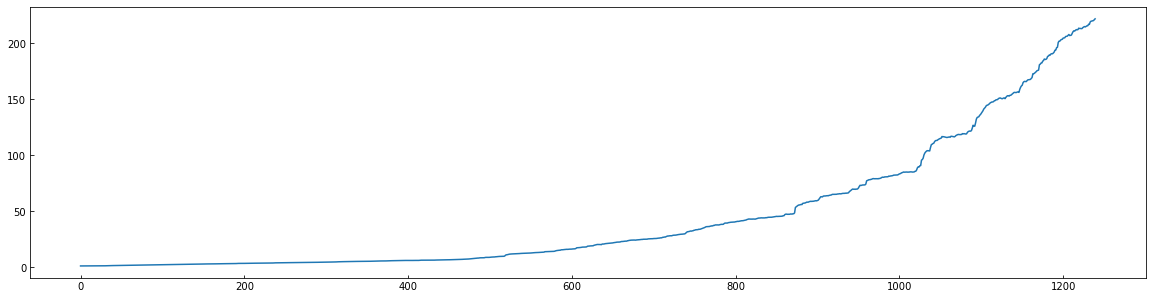

Wall time: 2h 18min 7s


In [171]:
%%time
# ret = -np.log(y.close).diff(-10)
end = ' 16:00:00'
start = ' 17:00:00'


long_windows = 60
short_windows = 10
timepoint = get_strike_day(c0)
for i in range(3):
    if (i == 0) | (i == 1):
        continue
    if i == 2:
        _y = y.loc[timepoint[i]+start:].fillna(method = 'ffill')
        _c0 = c0.loc[timepoint[i]+start:].fillna(method = 'ffill')
        _p0 = p0.loc[timepoint[i]+start:].fillna(method = 'ffill')
    else:
        _y = y.loc[timepoint[i]+start: timepoint[i+1]+end].fillna(method = 'ffill')
        _c0 = c0.loc[timepoint[i]+start: timepoint[i+1]+end].fillna(method = 'ffill')
        _p0 = p0.loc[timepoint[i]+start: timepoint[i+1]+end].fillna(method = 'ffill')
        
    position = []
    ret = -np.log(_c0.close).diff(-10)
    
    fac0 = np.log(_y.close).diff(long_windows)
    fac1 = np.log(_y.close).diff(short_windows)
    fac2 = np.log(_y.close).diff().rolling(long_windows).std()
    fac3 = np.log(_y.close).diff().rolling(short_windows).std()
    fac4 = ((_y.high - _y.low) / (_y.close + _y.open)).rolling(long_windows).mean()
    fac5 = ((_y.high - _y.low) / (_y.close + _y.open)).rolling(short_windows).mean()
    fac6 = _y.vol.rolling(long_windows).sum()
    fac7 = _y.vol.rolling(short_windows).sum()
    
    fac8 = np.log(_c0.close).diff(long_windows)
    fac9 = np.log(_c0.close).diff(short_windows)
    fac10 = np.log(_c0.close).diff().rolling(long_windows).std()
    fac11 = np.log(_c0.close).diff().rolling(short_windows).std()
    fac12 = ((_c0.high - _c0.low) / (_c0.close + _c0.open)).rolling(long_windows).mean()
    fac13 = ((_c0.high - _c0.low) / (_c0.close + _c0.open)).rolling(short_windows).mean()
    fac14 = _c0.vol.rolling(long_windows).sum()
    fac15 = _c0.vol.rolling(short_windows).sum()
    
    fac16 = np.log(_p0.close).diff(long_windows)
    fac17 = np.log(_p0.close).diff(short_windows)
    fac18 = np.log(_p0.close).diff().rolling(long_windows).std()
    fac19 = np.log(_p0.close).diff().rolling(short_windows).std()
    fac20 = ((_p0.high - _p0.low) / (_p0.close + _p0.open)).rolling(long_windows).mean()
    fac21 = ((_p0.high - _p0.low) / (_p0.close + _p0.open)).rolling(short_windows).mean()
    fac22 = _p0.vol.rolling(long_windows).sum()
    fac23 = _p0.vol.rolling(short_windows).sum()
    
    fac24 = (_c0.vol - _p0.vol) / (_c0.vol+_p0.vol+1).rolling(long_windows).mean()
    fac25 = (_c0.close.diff()) / (_y.close.diff()).rolling(long_windows).mean()
    fac26 = (_p0.close.diff()) / (_y.close.diff()).rolling(long_windows).mean()
    
    columns = ['fac{}'.format(i) for i in range(27)]
    factors = pd.concat(
        [fac0,fac1,fac2,fac3,fac4,fac5,fac6,fac7,fac8,fac9,fac10,fac11,fac12,fac13,fac14,fac15,fac16,fac17,fac18,fac19,fac20,fac21,fac22,fac23,fac24,fac25,fac26],
        axis = 1,
    )
    factors.columns = columns
    
    factors = factors.shift(30)
    
    Y = f(ret)
    X = factors.fillna(0).values
    for _i in range(1440, _y.shape[0]-120):
        X_train, Y_train =  X[_i-1440:_i,:], Y[_i-1440:_i]
        X_test, Y_test = X[_i:_i+1,:], Y[_i:_i+1]
        model = XGBClassifier(n_jobs = 7)
        r = model.fit(X_train, Y_train)
        prey = r.predict(X_test)
#         print(Y_test.iloc[0], ' ', prey[0])
        position.append(prey[0])
        print(_i-1440, ' / ', _y.shape[0]-1560, ' ',Y_test[0], ' ', prey[0])
            
    pos = np.array(position)
    a = ret[1440:]
    net = [[0.1] * 10]
    for ii in range(0, len(pos)//10):
        n = []
        for j in range(10):
            _ = net[-1][j] * (1+pos[10*ii+j] * a[10*ii+j])
            if (ii!=0) & (pos[10*ii+j] != pos[10*ii+j-10]):
                _ = _ * 0.998
            n.append(_)
        net.append(n)
        
    print(i)
    fig,ax = plt.subplots()
    ax.plot(np.array(net).sum(axis = 1))
    plt.show(fig)

## 实验

In [178]:
pos = np.array(position)
a = ret[1440:]
net = [[0.1] * 10]
for i in range(0, len(pos)//10):
    n = []
    for j in range(10):
        _ = net[-1][j] + pos[10*i+j] * a[10*i+j]
        if (i!=0) & (pos[10*i+j] != pos[10*i+j-10]):
            _ = _ - 0.002
        n.append(_)
    net.append(n)

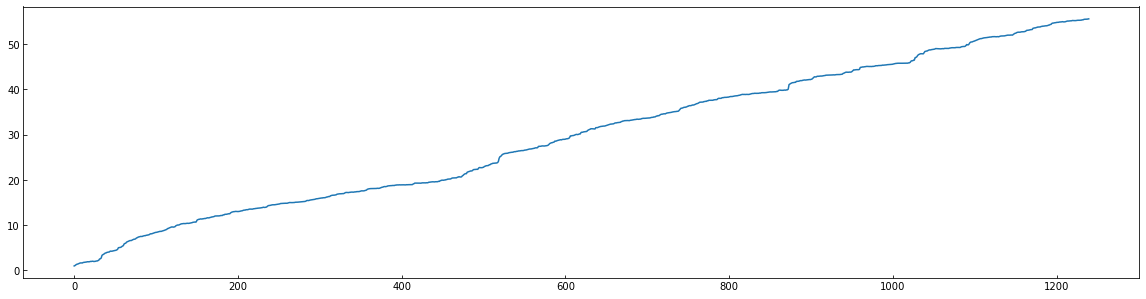

In [180]:
plt.plot(np.array(net).sum(axis = 1))

In [174]:
r.score(X_train,Y_train)

1.0

In [149]:
np.save('./pos/lipu.npy', pos)

In [172]:
count = 0
for i in range(len(pos)):
    if pos[i] == f(a[i]):
        count += 1

In [164]:
count/12392

0.665348612007747

In [166]:
np.mean(np.abs(a))

0.008138073702968806

In [169]:
np.power(300,1/30/14)

1.0136730674205212

In [173]:
count/12392

0.6507424144609425

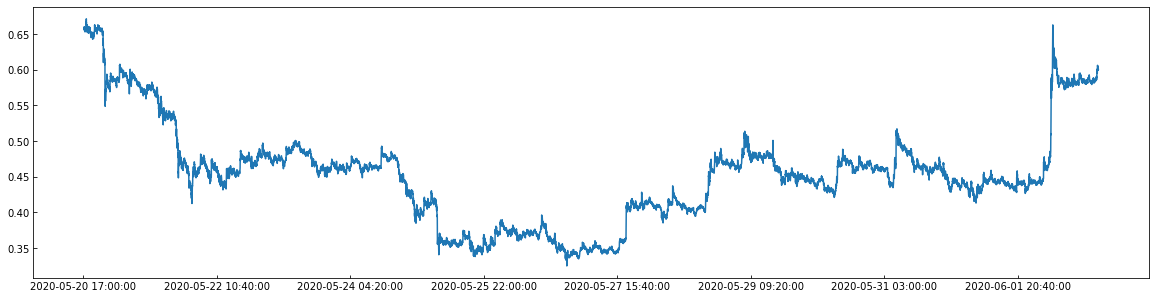

In [182]:
_c0.close.plot()

In [184]:
_c0.close.shape

(19012,)

In [185]:
a.shape

(17572,)

In [186]:
pos.shape

(12392,)

In [194]:
np.sum((a[:pos.shape[0]]  * pos) > 0.002)

7496

In [195]:
7496/12392

0.604906391220142

In [ ]:
a[]